In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Использовать только процессор.
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
# Изменить уровень отображения логов
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

# Корень проекта.
DIR_ROOT = Path.cwd().parent.parent
# Путь к удаленной директории с ресурсами: данные, модели и т.д.
DIR_REMOTE: Path | None = Path('/home/admin/cafa/resources')

if DIR_REMOTE is not None and DIR_REMOTE.exists():
    DIR_RESOURCE = DIR_REMOTE
else:
    DIR_RESOURCE = DIR_ROOT

# Утилиты

In [14]:
def get_basseline_model(n_inputs: int, n_outputs: int) -> tf.keras.Model:
    '''
    Возвращает скомпилированную DNN модель.
    '''
    model = tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(input_shape=(n_inputs,)),
        tf.keras.layers.Dense(units=512, activation='relu'),
        tf.keras.layers.Dense(units=512, activation='relu'),
        tf.keras.layers.Dense(units=512, activation='relu'),
        tf.keras.layers.Dense(units=n_outputs, activation='sigmoid'),
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
        loss='binary_crossentropy',
        metrics=['binary_accuracy'],
    )
    return model

def print_shape_and_total_memory(df: pd.DataFrame, prefix: str = '') -> None:
    print(
        prefix,
        f'Shape: {df.shape}',
        f'Total memory: {df.memory_usage().sum() / 1024**3:.1f} GB',
        '---',
        sep='\n',
    )

# Загрузка данных (признаков и целей)

In [3]:
# Загрузка признаков.
x = pd.read_csv(
    DIR_RESOURCE / 'data/prepared/train_features.csv',
)
# Загрузка целей.
y = pd.read_csv(
    DIR_RESOURCE / 'data/prepared/train_lbls_top1500_goterms.csv',
)
y = y.astype('int32')
print_shape_and_total_memory(x, 'x:')
print_shape_and_total_memory(y, 'y:')

# Обучение модели

In [38]:
BATCH_SIZE = 5120
VALIDATION_SPLIT = 0.2

model = get_basseline_model(x.shape[1], y.shape[1])
history = model.fit(
    x, y,
    batch_size=BATCH_SIZE,
    epochs=100,
    validation_split=VALIDATION_SPLIT,
)


Epoch 1/100
23/23 [==============================] - 16s 612ms/step - loss: 0.1807 - binary_accuracy: 0.9467 - val_loss: 0.5694 - val_binary_accuracy: 0.9845
Epoch 2/100
23/23 [==============================] - 11s 459ms/step - loss: 0.0816 - binary_accuracy: 0.9789 - val_loss: 0.5442 - val_binary_accuracy: 0.9842
Epoch 3/100
23/23 [==============================] - 10s 452ms/step - loss: 0.0760 - binary_accuracy: 0.9792 - val_loss: 0.5096 - val_binary_accuracy: 0.9843
Epoch 4/100
23/23 [==============================] - 10s 457ms/step - loss: 0.0711 - binary_accuracy: 0.9795 - val_loss: 0.4735 - val_binary_accuracy: 0.9845
Epoch 5/100
23/23 [==============================] - 11s 459ms/step - loss: 0.0682 - binary_accuracy: 0.9798 - val_loss: 0.4476 - val_binary_accuracy: 0.9845
Epoch 6/100
23/23 [==============================] - 11s 461ms/step - loss: 0.0662 - binary_accuracy: 0.9799 - val_loss: 0.4175 - val_binary_accuracy: 0.9848
Epoch 7/100
23/23 [==============================] -

Построение зависимости метрик от значения эпохи при обучении.

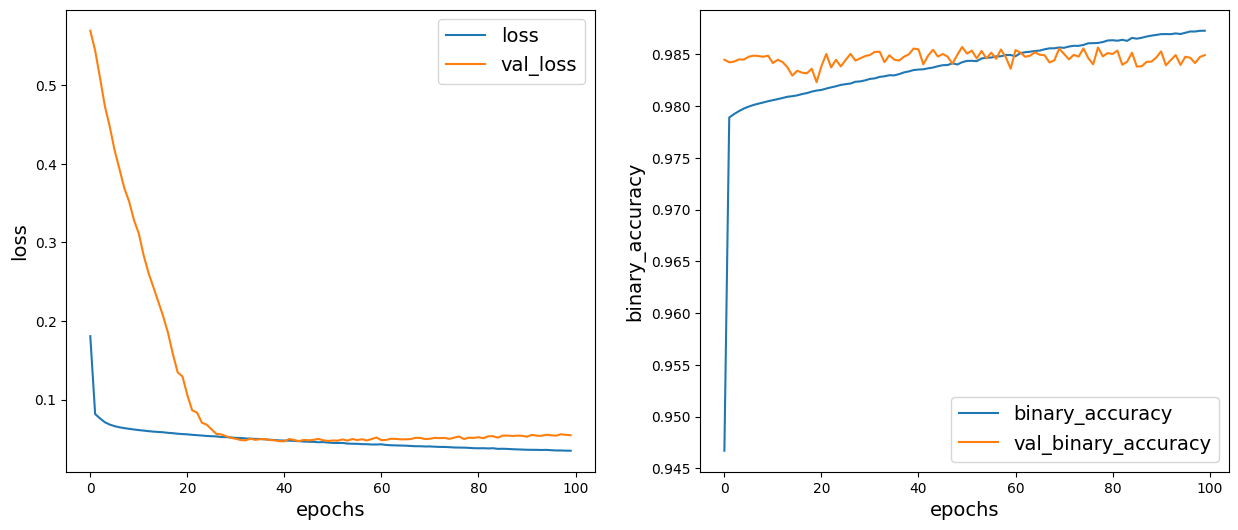

In [47]:
fontsize = 14
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax_dict = {
    0: ('loss', 'val_loss'),
    1: ('binary_accuracy', 'val_binary_accuracy'),
}
for ax_id, val in ax_dict.items():
    ax_i = ax[ax_id]
    ax_i.plot(history.history[val[0]], label=val[0])
    ax_i.plot(history.history[val[1]], label=val[1])
    ax_i.set_xlabel('epochs', fontsize=fontsize,)
    ax_i.set_ylabel(val[0], fontsize=fontsize)
    ax_i.legend(fontsize=fontsize)
